### 데이터 불러오기

In [1]:
import sklearn
print(sklearn.__version__)

1.6.1


In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
plt.rc('font', family='Malgun Gothic')  # Windows: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 적용 시 마이너스 부호 깨짐 방지
train.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


In [3]:

# 4 LabelEncoder를 사용하여 문자형을 숫자형으로 변환
categorical_features = ['매물확인방식', '주차가능여부', '제공플랫폼', '방향', '중개사무소']
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))  # astype(str)로 변환 후 처리
    test[col] = test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le
print(train.columns)  # 모든 컬럼명을 출력해서 '게재일'이 정확한지 확인
# 1️⃣ 게재일을 날짜 형식으로 변환
# 1️⃣ 날짜 데이터 변환 (NaT 발생 시 자동 처리)
train["게재일"] = pd.to_datetime(train["게재일"], errors="coerce")
test["게재일"] = pd.to_datetime(test["게재일"], errors="coerce")
# 2️⃣ 기준 날짜 설정 (최소 날짜를 0으로)
min_date = train["게재일"].min()
min_date_test = test["게재일"].min()
train["게재일_변환"] = (train["게재일"] - min_date).dt.days
test["게재일_변환"] = (test["게재일"] - min_date_test).dt.days
# 3️⃣ 기존 '게재일' 컬럼 삭제
train.drop(columns=["게재일"], inplace=True)
test.drop(columns=["게재일"], inplace=True)
# 4️⃣ 결측치 채우기 (NaT가 있는 경우, 중앙값 또는 최빈값으로)
train["게재일_변환"].fillna(train["게재일_변환"].median())
test["게재일_변환"].fillna(test["게재일_변환"].median())
# 5️⃣ 다른 결측치 처리 (수치형 데이터는 중앙값, 범주형 데이터는 최빈값)
num_cols = train.select_dtypes(include=["float64", "int64"]).columns
cat_cols = train.select_dtypes(include=["object"]).columns

num_cols_test = test.select_dtypes(include=["float64", "int64"]).columns
cat_cols_test = test.select_dtypes(include=["object"]).columns


Index(['ID', '매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수',
       '주차가능여부', '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일', '허위매물여부'],
      dtype='object')


In [4]:
# 결측치 확인
missing_values = train.isnull().sum()  # 각 컬럼별 결측치 개수 확인
missing_values = missing_values[missing_values > 0]  # 결측치가 있는 컬럼만 필터링
print("🔍 결측치 개수:\n", missing_values)

# 🔹 전체 데이터에서 결측치 비율 확인
missing_ratio = (train.isnull().sum() / len(train)) * 100  # 퍼센트로 변환
missing_ratio = missing_ratio[missing_ratio > 0]  # 결측치가 있는 컬럼만 출력
print("📊 결측치 비율(%):\n", missing_ratio)

🔍 결측치 개수:
 전용면적     787
해당층      229
총층        16
방수        16
욕실수       18
총주차대수    696
dtype: int64
📊 결측치 비율(%):
 전용면적     32.096248
해당층       9.339315
총층        0.652529
방수        0.652529
욕실수       0.734095
총주차대수    28.384992
dtype: float64


<Figure size 1000x600 with 0 Axes>

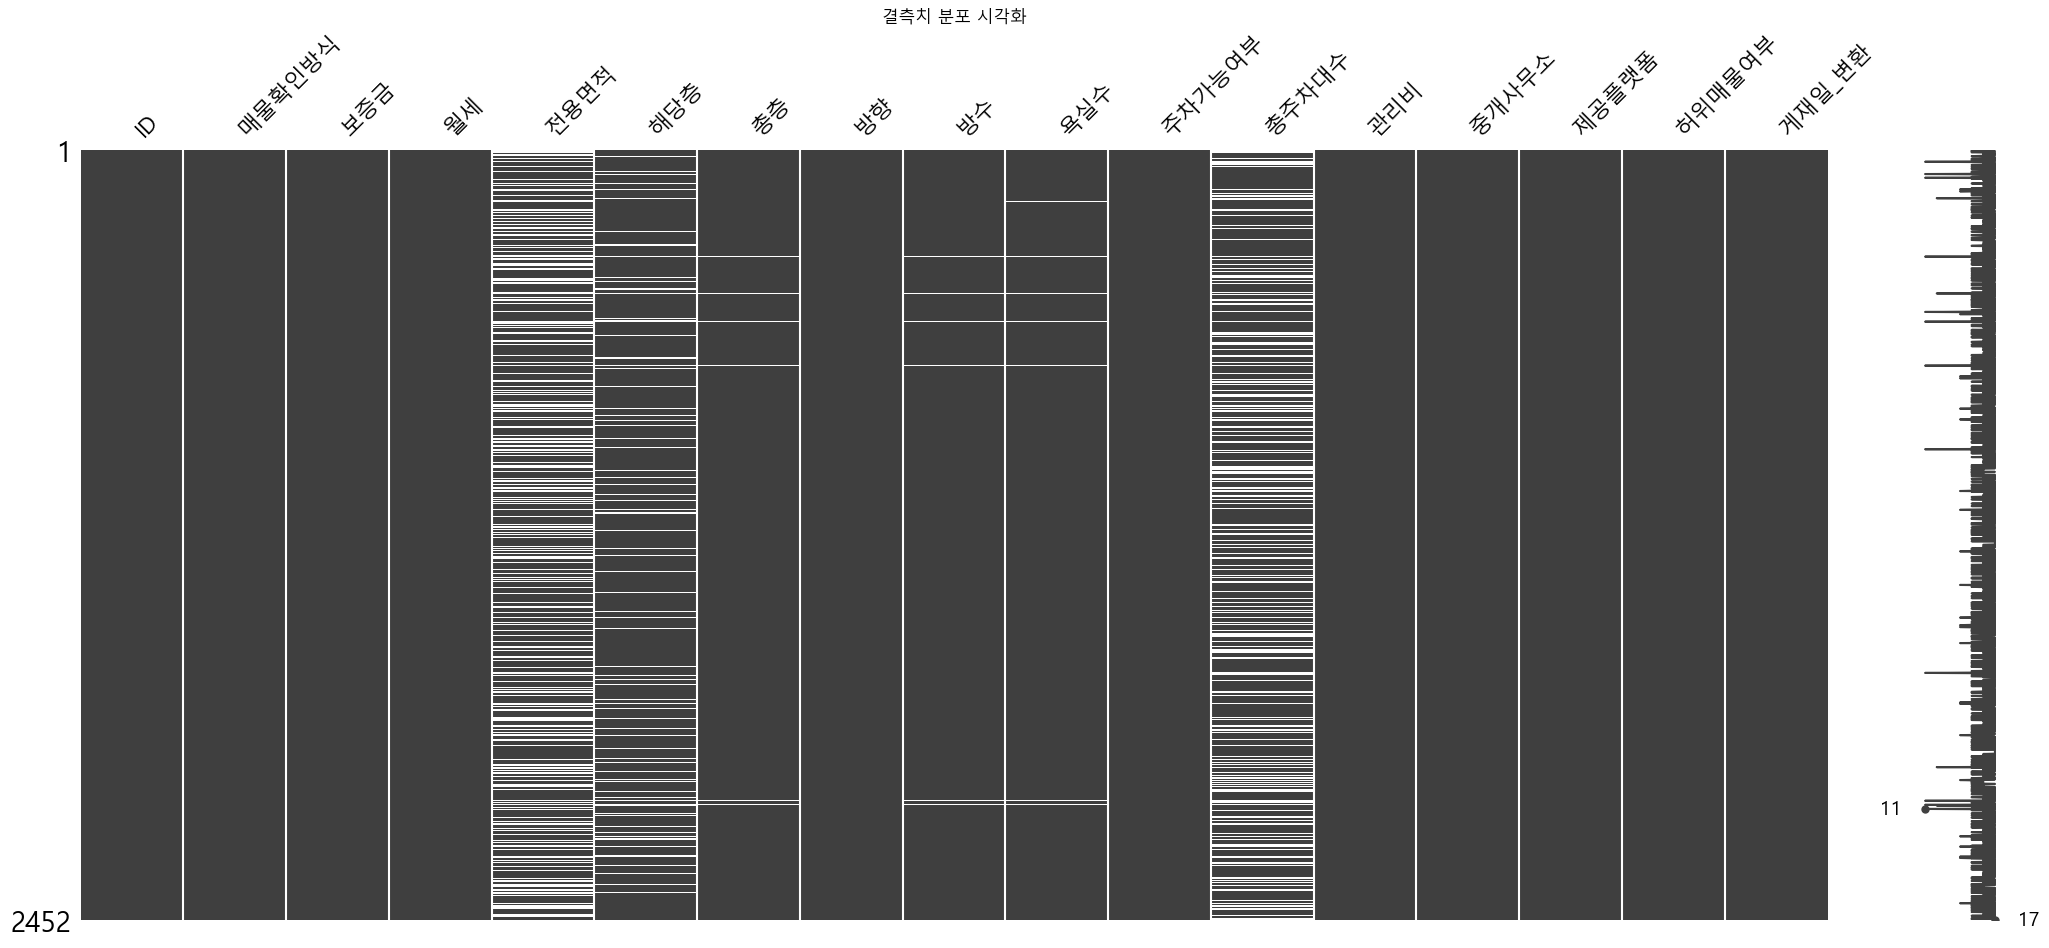

✅ 남은 결측치 개수:
 ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      787
해당층       229
총층         16
방향          0
방수         16
욕실수        18
주차가능여부      0
총주차대수     696
관리비         0
중개사무소       0
제공플랫폼       0
허위매물여부      0
게재일_변환      0
dtype: int64
           ID  매물확인방식          보증금      월세  전용면적  해당층    총층  방향   방수  욕실수  \
0  TRAIN_0000       2  402500000.0  470000   NaN  NaN  15.0   7  1.0  1.0   
1  TRAIN_0001       2  170500000.0  200000   NaN  3.0   4.0   0  2.0  1.0   
2  TRAIN_0002       1  114000000.0  380000   NaN  2.0   3.0   3  1.0  1.0   
3  TRAIN_0003       2  163500000.0   30000  36.3  3.0   9.0   0  2.0  1.0   
4  TRAIN_0004       2  346000000.0  530000   NaN  3.0   3.0   3  2.0  1.0   

   주차가능여부  총주차대수  관리비  중개사무소  제공플랫폼  허위매물여부  게재일_변환  
0       0   40.0   96    240      1       0     530  
1       1    NaN    0    228      3       0     608  
2       1    NaN    0    150      0       0     580  
3       0   13.0   10     31      0       0     578  
4 

In [6]:

# 🔹 결측치 분포 시각화
plt.rc('font', family='Malgun Gothic')  # Windows: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 적용 시 마이너스 부호 깨짐 방지

plt.figure(figsize=(10, 6))
msno.matrix(train)
plt.title("결측치 분포 시각화")
plt.show()
print("✅ 남은 결측치 개수:\n", train.isnull().sum())
categorical_features = ['매물확인방식', '방향', '주차가능여부', '제공플랫폼', '게재일']



# 변환 후 데이터 확인
print(train.head())  # 제대로 변환됐는지 확인

In [ ]:
import numpy as np

# 1️⃣ 보증금과 월세를 기준으로 5개 구간으로 나누기
train['보증금_그룹'], bins_deposit = pd.qcut(train['보증금'], q=5, labels=False, retbins=True)
train['월세_그룹'], bins_rent = pd.qcut(train['월세'], q=5, labels=False, retbins=True)

# 2️⃣ 각 그룹별 전용면적 중앙값 계산 및 결측치 채우기
grouped_median_area = train.groupby(['보증금_그룹', '월세_그룹'])['전용면적'].median()

def fill_area(row):
    return grouped_median_area.get((row['보증금_그룹'], row['월세_그룹']), train['전용면적'].median()) if pd.isnull(row['전용면적']) else row['전용면적']

train['전용면적'] = train.apply(fill_area, axis=1)
train['전용면적_그룹'], bins_area = pd.qcut(train['전용면적'], q=5, labels=False, retbins=True)

# 3️⃣ 총층 중앙값 계산 및 결측치 채우기
grouped_median_floors = train.groupby(['보증금_그룹', '월세_그룹', '전용면적_그룹'])['총층'].median()

def fill_floors(row):
    return grouped_median_floors.get((row['보증금_그룹'], row['월세_그룹'], row['전용면적_그룹']), train['총층'].median()) if pd.isnull(row['총층']) else row['총층']

train['총층'] = train.apply(fill_floors, axis=1)
train['총층_그룹'], bins_floor = pd.qcut(train['총층'], q=4, labels=False, retbins=True)

# 4️⃣ 방수 결측치 채우기 (전용면적 그룹 기반 중앙값)
grouped_rooms = train.groupby(['전용면적_그룹'])['방수'].median()

def fill_rooms(row):
    return grouped_rooms.get(row['전용면적_그룹'], train['방수'].median()) if pd.isnull(row['방수']) else row['방수']

train['방수'] = train.apply(fill_rooms, axis=1)

# 5️⃣ 해당층 결측치 채우기 (총층 비례 적용)
train['층비율'] = train['해당층'] / train['총층']
median_floor_ratio = train['층비율'].median()  # 층비율 중앙값 계산

def fill_floor(row):
    if pd.isnull(row['해당층']):
        if pd.notnull(row['총층']):  # 총층 값이 있을 때만 비례 적용
            return row['총층'] * median_floor_ratio
        else:  # 총층도 NaN이면 해당층의 중앙값 사용
            return train['해당층'].median()
    return row['해당층']

train['해당층'] = train.apply(fill_floor, axis=1)

# 6️⃣ 총주차대수 결측치 채우기 (최빈값으로 채우기)
most_common_parking = train['총주차대수'].mode()[0]  # 최빈값 계산
train['총주차대수'].fillna(most_common_parking, inplace=True)


In [6]:
# 6️⃣ Test 데이터에서 Train과 동일한 구간 적용 (bins 사용)
test['보증금_그룹'] = pd.cut(test['보증금'], bins=bins_deposit, labels=False, include_lowest=True)
test['월세_그룹'] = pd.cut(test['월세'], bins=bins_rent, labels=False, include_lowest=True)

# 7️⃣ 전용면적 결측치 채우기
test['전용면적'] = test.apply(fill_area, axis=1)

# 8️⃣ Train에서 만든 '전용면적_그룹' 기준 적용
test['전용면적_그룹'] = pd.cut(test['전용면적'], bins=bins_area, labels=False, include_lowest=True)

# 9️⃣ 총층 결측치 채우기 (Train 기준)
test['총층'] = test.apply(fill_floors, axis=1)

# 🔟 Train에서 만든 '총층_그룹' 기준 적용
test['총층_그룹'] = pd.cut(test['총층'], bins=bins_floor, labels=False, include_lowest=True)

# 11️⃣ 방수, 총주차대수 결측치 채우기
test['방수'] = test.apply(lambda row: grouped_rooms.get(row['전용면적_그룹'], train['방수'].median()) if pd.isnull(row['방수']) else row['방수'], axis=1)
test['총주차대수'] = test.apply(lambda row: grouped_parking.get((row['총층_그룹'], row['전용면적_그룹']), train['총주차대수'].median()) if pd.isnull(row['총주차대수']) else row['총주차대수'], axis=1)

# 12️⃣ 해당층 결측치 채우기
test['해당층'] = test.apply(lambda row: grouped_floor.get(row['총층'], train['해당층'].median()) if pd.isnull(row['해당층']) else row['해당층'], axis=1)
test['해당층'] = test['해당층'].fillna(train['해당층'].median())
test['해당층'] = test['해당층'].fillna(train['해당층'].mode()[0])

# 13️⃣ 보조 컬럼 삭제 (Train과 동일한 형태 유지)
train.drop(columns=['보증금_그룹', '월세_그룹', '전용면적_그룹', '총층_그룹'], inplace=True)
test.drop(columns=['보증금_그룹', '월세_그룹', '전용면적_그룹', '총층_그룹'], inplace=True)

print("✅ Test 데이터 결측치 채우기 완료!")

✅ Test 데이터 결측치 채우기 완료!


In [9]:
catboost_train = train.copy()
lightgbm_train = train.copy()

In [7]:
train.isnull().sum()
train = train.drop(columns=['ID', '매물확인방식', '방수', '욕실수'])
test = test.drop(columns=['ID', '매물확인방식', '방수', '욕실수'])

In [13]:
train.head()

,보증금,월세,전용면적,해당층,총층,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,게재일_변환,방향_0,방향_1,방향_2,방향_3,방향_4,방향_5,방향_6,방향_7
0,402500000.0,470000,25.97,NaN,15.0,0,40.0,96,240,1,0,530,False,False,False,False,False,False,False,True
1,170500000.0,200000,25.29,3.0,4.0,1,NaN,0,228,3,0,608,True,False,False,False,False,False,False,False
2,114000000.0,380000,28.27,2.0,3.0,1,NaN,0,150,0,0,580,False,False,False,True,False,False,False,False
3,163500000.0,30000,36.30,3.0,9.0,0,13.0,10,31,0,0,578,True,False,False,False,False,False,False,False
4,346000000.0,530000,25.97,3.0,3.0,1,NaN,0,72,1,1,424,False,False,False,True,False,False,False,False


In [12]:
#One-hot incoding하기 전, 중요도 파악.

X = train.drop(columns=['허위매물여부'])
y = train['허위매물여부']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("📊 Feature Importance:")
print(feature_importance_df.head(20))



📊 Feature Importance:
   Feature  Importance
14  게재일_변환    0.386907
12   중개사무소    0.137036
10   총주차대수    0.089601
11     관리비    0.064127
5       총층    0.049437
6       방향    0.045251
4      해당층    0.044566
2       월세    0.043803
1      보증금    0.041031
3     전용면적    0.035646
9   주차가능여부    0.022894
13   제공플랫폼    0.019192
0   매물확인방식    0.009312
7       방수    0.008860
8      욕실수    0.002337


In [13]:
print("🔹 X의 컬럼 목록:", X.columns.tolist())
print("🔹 X_train의 컬럼 목록:", X_train.columns.tolist())


🔹 X의 컬럼 목록: ['매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수', '주차가능여부', '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일_변환']
🔹 X_train의 컬럼 목록: ['매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수', '주차가능여부', '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일_변환']


In [14]:
#위에서 분석한 중요도를 바탕으로 컬럼을 제거

In [9]:
#방향은 중요도가 어느정도 있으므로 one-hot incoding
train = pd.get_dummies(train, columns=['방향'])
test = pd.get_dummies(test, columns=['방향'])

In [14]:
train.head()

,보증금,월세,전용면적,해당층,총층,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,게재일_변환,방향_0,방향_1,방향_2,방향_3,방향_4,방향_5,방향_6,방향_7
0,402500000.0,470000,25.97,NaN,15.0,0,40.0,96,240,1,0,530,False,False,False,False,False,False,False,True
1,170500000.0,200000,25.29,3.0,4.0,1,NaN,0,228,3,0,608,True,False,False,False,False,False,False,False
2,114000000.0,380000,28.27,2.0,3.0,1,NaN,0,150,0,0,580,False,False,False,True,False,False,False,False
3,163500000.0,30000,36.30,3.0,9.0,0,13.0,10,31,0,0,578,True,False,False,False,False,False,False,False
4,346000000.0,530000,25.97,3.0,3.0,1,NaN,0,72,1,1,424,False,False,False,True,False,False,False,False


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# 1️⃣ 입력 데이터 및 타겟 변수 분리
X = train.drop(columns=['허위매물여부'])  # 입력 변수
y = train['허위매물여부']  # 타겟 변수

# 2️⃣ 훈련 데이터와 테스트 데이터 분리 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




# 4️⃣ 랜덤포레스트 모델 초기화 및 학습 (클래스 불균형 반영)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# 5️⃣ 예측 수행
y_pred = rf_model.predict(X_test)

# 6️⃣ 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 7️⃣ Feature Importance 분석 (중요하지 않은 변수 제거 가능)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 상위 20개 중요 변수 확인
print(feature_importance_df.head(20))


Accuracy: 0.9348268839103869
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       431
           1       0.85      0.57      0.68        60

    accuracy                           0.93       491
   macro avg       0.90      0.78      0.82       491
weighted avg       0.93      0.93      0.93       491

   Feature  Importance
10  게재일_변환    0.389430
8    중개사무소    0.143008
6    총주차대수    0.089829
7      관리비    0.070817
4       총층    0.050986
1       월세    0.045058
0      보증금    0.044109
3      해당층    0.042105
2     전용면적    0.034923
5   주차가능여부    0.021594
9    제공플랫폼    0.017573
17    방향_6    0.011440
13    방향_2    0.009497
18    방향_7    0.009229
14    방향_3    0.006095
16    방향_5    0.004315
15    방향_4    0.003662
11    방향_0    0.003254
12    방향_1    0.003076


In [12]:

# 5️⃣ 예측 수행 (test.csv에 대해 학습된 모델로 예측)
test_predictions = rf_model.predict(test)

# 6️⃣ 제출 파일 생성
submission = pd.read_csv('./sample_submission.csv')
submission['허위매물여부'] = test_predictions  # 결과 컬럼 반영
submission.to_csv('submission.csv', index=False)

print("✅ 제출 파일 (submission.csv) 생성 완료!")



✅ 제출 파일 (submission.csv) 생성 완료!


### 데이터 전처리

### 학습하기

### 예측하기

In [19]:
# Test 데이터 로드
test = pd.read_csv('./test.csv')

In [20]:
# Test 결측값 대체
test[columns_fill_mean] = mean_imputer.transform(test[columns_fill_mean])

NameError: name 'mean_imputer' is not defined

In [ ]:
# Label Encoding
for col in label_encode_cols:
    if col in test.columns:
        le = label_encoders[col]
        test[col] = test[col].astype(str)
        unseen = set(test[col].unique()) - set(le.classes_)
        if unseen:
            le.classes_ = np.append(le.classes_, list(unseen))
        test[col] = le.transform(test[col])

In [ ]:
# One-Hot Encoding
test_encoded = one_hot_encoder.transform(test[one_hot_cols])
test_encoded_df = pd.DataFrame(test_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=test.index)

test = pd.concat([test.drop(columns=one_hot_cols), test_encoded_df], axis=1)

In [ ]:
test.drop(columns=['ID'],inplace=True)

In [ ]:
pred = pd.Series(model.predict(test))

### 제출하기

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['허위매물여부'] = pred
submit.head()

In [ ]:
submit.to_csv('./baseline_submission.csv',index=False)